In [2]:
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

In [3]:
d_path = "eeg_files/20241017_kp.bdf" 
ch_eog = ["EXG1","EXG2"] #kanaly eog
ch_ecg = ["EXG3","EXG4"] #kanaly ecg
ch_exclude = [f"EXG{i}" for i in range(5,9)]



In [4]:
raw = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
#załadowanie danych

Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...


In [5]:
raw.set_montage("biosemi64") #ustawienie montazu biosemi

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [6]:
bandpass_low = 0.1 #dolne pasmo
bandpass_high = 50 #górne pasmo
notch = 50 
raw.notch_filter(notch)
raw.filter(bandpass_low,bandpass_high) 


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 67585 samples (33.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [9]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


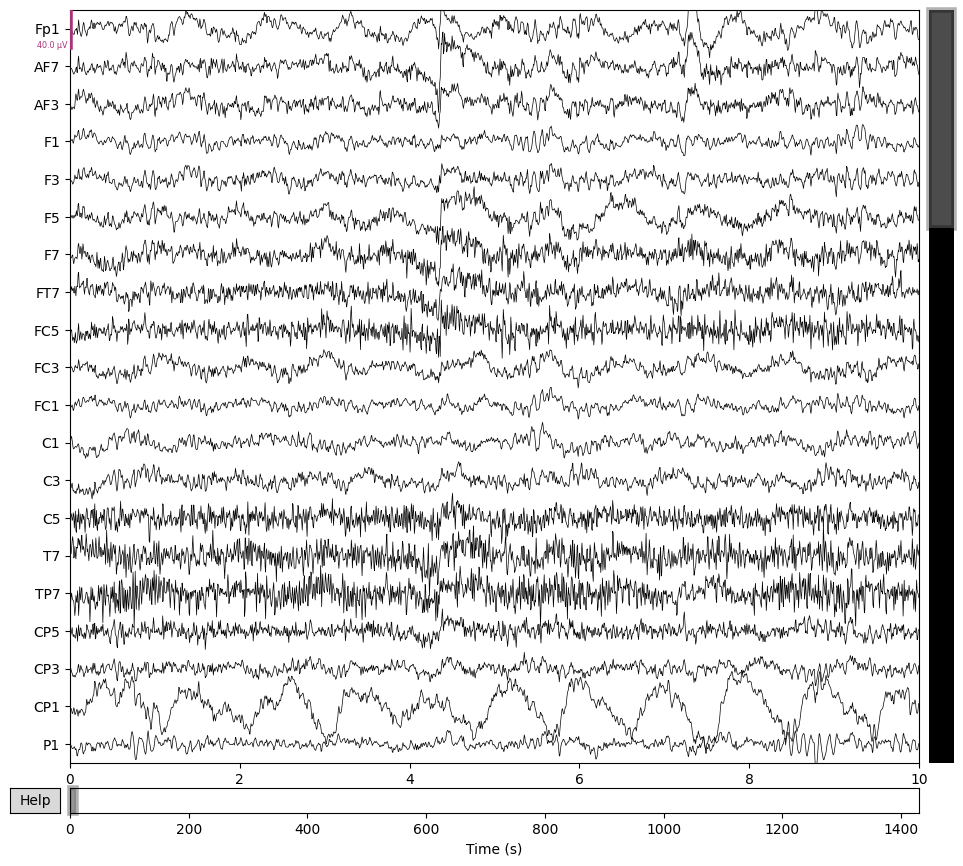

Channels marked as bad:
none


In [10]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=100.0)#dla algorytmu ica-label
filt_raw.set_montage("biosemi64")
filt_raw.set_eeg_reference("average")
filt_raw.plot()

In [11]:
ica = ICA(
    max_iter="auto",  #automatyczna liczba iteracji
    method="infomax",  #wymog ica-label
    random_state=97, #ziarno
    fit_params=dict(extended=True), #wymog ica-label
)
ica.fit(filt_raw)  


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA
Fitting ICA took 1123.5s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (2928640 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [12]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for eeg,ratio in explained_var_ratio.items():
    print(f"Dla sygnału {eeg}, wariancja określona przez wszystkie komponenty ica wynosi: {ratio*100} % ") 

Dla sygnału eeg, wariancja określona przez wszystkie komponenty ica wynosi: 100.0 % 


In [13]:
ica.plot_components()

[<MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 585x260 with 3 Axes>]

In [271]:
eog_indices, eog_scores = ica.find_bads_eog(raw, measure="correlation",threshold=0.6)


Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



In [28]:
ica.plot_properties(raw,picks = eog_indices)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [104]:
ica.plot_components()

[<MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 585x260 with 3 Axes>]

In [65]:
ch_heart = "EXG3" #kanał EKG z o najlepszej jakości
ecg_indices, ecg_scores = ica.find_bads_ecg(raw,ch_name = ch_heart,measure="correlation")


Using threshold: 0.12 for CTPS ECG detection
Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1377 (average pulse 57.77622377622378 / min.)
Not setting metadata
1377 matching events found
No baseline correction applied
Using data from preloaded Raw for 1377 events and 2049 original time points ...
0 bad epochs dropped


In [69]:

print(ecg_indices)
ica.plot_properties(raw, picks=[46])

[np.int64(13), np.int64(46), np.int64(8)]
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

In [68]:
print(ecg_scores[[13,46,8]])

[0.5373456  0.13920321 0.13521915]


In [364]:
ic_labels = label_components(filt_raw, ica, method='iclabel')
print(ic_labels["labels"])

/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_56149/3132314654.py:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(filt_raw, ica, method='iclabel')


['eye blink', 'eye blink', 'eye blink', 'other', 'eye blink', 'brain', 'other', 'channel noise', 'other', 'brain', 'eye blink', 'other', 'brain', 'brain', 'eye blink', 'other', 'muscle artifact', 'other', 'other', 'muscle artifact', 'other', 'other', 'muscle artifact', 'other', 'muscle artifact', 'other', 'muscle artifact', 'other', 'muscle artifact', 'other', 'other', 'muscle artifact', 'brain', 'muscle artifact', 'other', 'muscle artifact', 'other', 'eye blink', 'eye blink', 'muscle artifact', 'brain', 'other', 'muscle artifact', 'other', 'channel noise', 'channel noise', 'other', 'other', 'muscle artifact', 'channel noise', 'other', 'other', 'channel noise', 'other', 'muscle artifact', 'channel noise', 'brain', 'brain', 'eye blink', 'other', 'other', 'other', 'other']


In [174]:
print(ic_labels["labels"])
print(ic_labels['labels'][13])

['eye blink', 'eye blink', 'eye blink', 'other', 'eye blink', 'brain', 'other', 'channel noise', 'other', 'brain', 'eye blink', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'muscle artifact', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'muscle artifact', 'brain', 'muscle artifact', 'other', 'muscle artifact', 'other', 'other', 'eye blink', 'other', 'other', 'other', 'muscle artifact', 'other', 'channel noise', 'channel noise', 'other', 'other', 'other', 'channel noise', 'other', 'other', 'channel noise', 'other', 'muscle artifact', 'channel noise', 'brain', 'other', 'channel noise', 'other', 'other', 'other', 'other']
other


In [179]:
ica.plot_properties(raw,picks=[53,46,41])
print(eog_scores)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
[array([ 6.54960370e-01, -3.53129844e-01,  1.79046044e-02, -1.36774351e-02,
       -1.99459705e-02, -2.21415718e-01, -6.22174484e-02, -2.22712379e-03,
        6.25750426e-04,  2.76555624e-01,  5.92256055e-02, -1.68611892e-03,
        1.17238790e-01,  5.41308202e-03,  7.40050852e-03,  2.07206180e-02,
        1.72004719e-02,  7.33249696e-02,  2.04594977e-02, -4.60453640e-02,
       -5.08012237e-02,  7.90452075e-02, -2.05266368e-02,  1.20427511e-02,
       -9.68941271e-03, -1.15256189e-02, -2.19148583e-02,  6.50744100e-02,
       -9.38354048e-03, -1.72932961e-02, -4.63727810e-02, -4.70947343e-02,
       -9.1895638

Creating RawArray with float64 data, n_channels=3, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


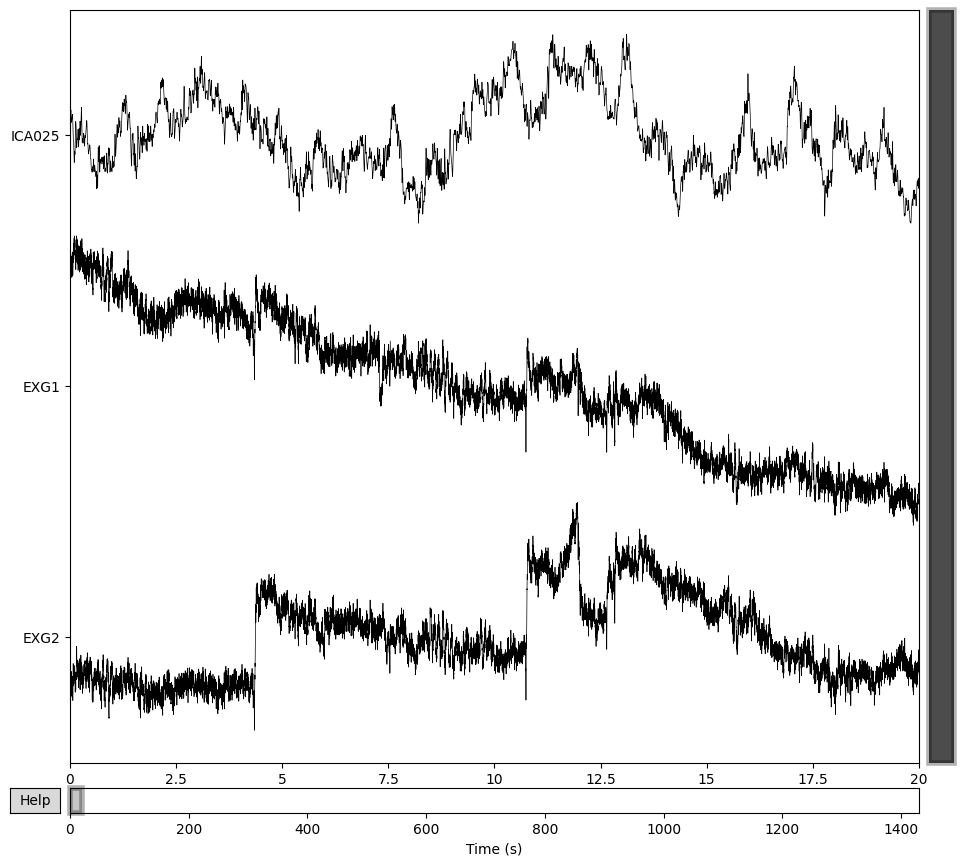

2025-05-06 16:47:28.697 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-06 16:47:28.697 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-06 16:47:28.697 Python[56149:7936693] Text input context does not respond to _valueForTIProperty:


In [359]:
ica.plot_sources(raw,picks=[25])

In [180]:
ica.save("moje_rozwiazanie_ica-ica.fif",overwrite=True) 

Writing ICA solution to /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/moje_rozwiazanie_ica-ica.fif...


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (2928640 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


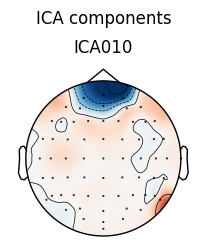

2025-05-06 16:48:07.802 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-06 16:48:07.802 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-06 16:48:07.802 Python[56149:7936693] Text input context does not respond to _valueForTIProperty:
2025-05-06 16:48:09.894 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-06 16:48:09.894 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-06 16:48:09.894 Python[56149:7936693] Text input context does not respond to _valueForTIProperty:


In [360]:
ica.plot_components(picks=[10])

In [187]:
print(eog_scores)

[array([ 6.54960370e-01, -3.53129844e-01,  1.79046044e-02, -1.36774351e-02,
       -1.99459705e-02, -2.21415718e-01, -6.22174484e-02, -2.22712379e-03,
        6.25750426e-04,  2.76555624e-01,  5.92256055e-02, -1.68611892e-03,
        1.17238790e-01,  5.41308202e-03,  7.40050852e-03,  2.07206180e-02,
        1.72004719e-02,  7.33249696e-02,  2.04594977e-02, -4.60453640e-02,
       -5.08012237e-02,  7.90452075e-02, -2.05266368e-02,  1.20427511e-02,
       -9.68941271e-03, -1.15256189e-02, -2.19148583e-02,  6.50744100e-02,
       -9.38354048e-03, -1.72932961e-02, -4.63727810e-02, -4.70947343e-02,
       -9.18956385e-03, -1.41990773e-02,  3.19871248e-02, -6.38204518e-03,
       -3.89674395e-02, -5.09935036e-03,  2.31250819e-02,  6.12597216e-03,
        3.05055637e-02,  2.69741584e-02, -3.18069516e-02,  5.23752721e-02,
        9.23000623e-03, -2.03617461e-02, -3.60843183e-02, -1.94298139e-02,
       -5.96031240e-03,  1.32563013e-02, -2.84070032e-02,  4.72046720e-04,
        6.16270527e-03, 

In [188]:
print(eog_scores)

[array([ 6.54960370e-01, -3.53129844e-01,  1.79046044e-02, -1.36774351e-02,
       -1.99459705e-02, -2.21415718e-01, -6.22174484e-02, -2.22712379e-03,
        6.25750426e-04,  2.76555624e-01,  5.92256055e-02, -1.68611892e-03,
        1.17238790e-01,  5.41308202e-03,  7.40050852e-03,  2.07206180e-02,
        1.72004719e-02,  7.33249696e-02,  2.04594977e-02, -4.60453640e-02,
       -5.08012237e-02,  7.90452075e-02, -2.05266368e-02,  1.20427511e-02,
       -9.68941271e-03, -1.15256189e-02, -2.19148583e-02,  6.50744100e-02,
       -9.38354048e-03, -1.72932961e-02, -4.63727810e-02, -4.70947343e-02,
       -9.18956385e-03, -1.41990773e-02,  3.19871248e-02, -6.38204518e-03,
       -3.89674395e-02, -5.09935036e-03,  2.31250819e-02,  6.12597216e-03,
        3.05055637e-02,  2.69741584e-02, -3.18069516e-02,  5.23752721e-02,
        9.23000623e-03, -2.03617461e-02, -3.60843183e-02, -1.94298139e-02,
       -5.96031240e-03,  1.32563013e-02, -2.84070032e-02,  4.72046720e-04,
        6.16270527e-03, 

Creating RawArray with float64 data, n_channels=65, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


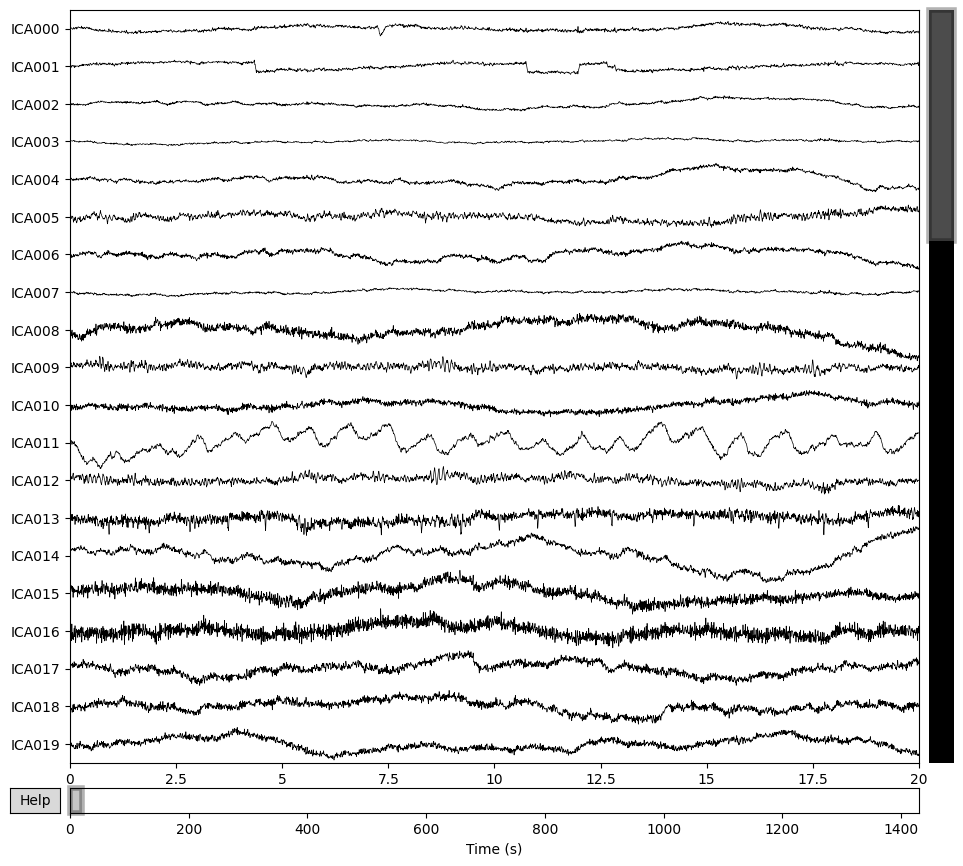

In [189]:
ica.plot_sources(raw)

In [205]:
print(ic_labels["labels"][[8,15,23]])

TypeError: list indices must be integers or slices, not list

In [198]:
muscle_indices,muscle_scores = ica.find_bads_muscle(raw)
print(muscle_indices)

Effective window size : 1.000 (s)
[2, 4, 8, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 30, 31, 33, 35, 37, 38, 39, 41, 42, 48, 51, 54, 58]


In [298]:
"""SPRAWDZENIE INDEKSÓW DLA KLASYFIKATORA"""
idx_to_check = [15,16,17,18,19,20,21,23,24,26,28,30,37,38,39,41,48,51,58]
for idx in idx_to_check:
    checked_label = ic_labels["labels"][idx]
    print(f"Indeks: {idx}, klasyfikator ICA-label oznaczył jako: {checked_label}") 

Indeks: 15, klasyfikator ICA-label oznaczył jako: other
Indeks: 16, klasyfikator ICA-label oznaczył jako: other
Indeks: 17, klasyfikator ICA-label oznaczył jako: other
Indeks: 18, klasyfikator ICA-label oznaczył jako: other
Indeks: 19, klasyfikator ICA-label oznaczył jako: brain
Indeks: 20, klasyfikator ICA-label oznaczył jako: other
Indeks: 21, klasyfikator ICA-label oznaczył jako: other
Indeks: 23, klasyfikator ICA-label oznaczył jako: other
Indeks: 24, klasyfikator ICA-label oznaczył jako: brain
Indeks: 26, klasyfikator ICA-label oznaczył jako: other
Indeks: 28, klasyfikator ICA-label oznaczył jako: other
Indeks: 30, klasyfikator ICA-label oznaczył jako: other
Indeks: 37, klasyfikator ICA-label oznaczył jako: other
Indeks: 38, klasyfikator ICA-label oznaczył jako: eye blink
Indeks: 39, klasyfikator ICA-label oznaczył jako: other
Indeks: 41, klasyfikator ICA-label oznaczył jako: other
Indeks: 48, klasyfikator ICA-label oznaczył jako: other
Indeks: 51, klasyfikator ICA-label oznaczył 

In [297]:
"""METODA Z-SCORE"""
eog_indices_2, eog_scores_2 = ica.find_bads_eog(raw)
print(eog_indices_2)
    

Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

[np.int64(1), np.int64(0), np.int64(9), np.int64(5)]


In [293]:
"""ARTEFAKTY WZROKOWE find_bads_eog Z-SCORE"""
eog_z_score_components = []
for idx in eog_indices_2:
    eog_z_score_components.append(f"ICA00{idx}")



print(f"Komponenty artefaktów wzrokowych, rozpoznane przy pomocy funkcji find_bads_eog wykorzystując metrykę z-score \nto : \n  {eog_z_score_components} ")


Komponenty artefaktów wzrokowych, rozpoznane przy pomocy funkcji find_bads_eog wykorzystując metrykę z-score 
to : 
  ['ICA001', 'ICA000', 'ICA009', 'ICA005'] 


In [294]:
"""ARTEFAKTY WZROKOWE find_bads_eog CORRELATION"""
eog_correlation_metric_components = []
for idx_correlation in eog_indices:
    eog_correlation_metric_components.append(f"ICA00{idx_correlation}")

print(f"Komponenty artefaktów wzrokowych, rozpoznane przy pomocy funkcji find_bads_eog wykorzystując metrykę  correlation to : \n  {eog_correlation_metric_components} ")


Komponenty artefaktów wzrokowych, rozpoznane przy pomocy funkcji find_bads_eog wykorzystując metrykę  correlation to : 
  ['ICA001', 'ICA000'] 


In [295]:
"""ARTEFAKTY WZROKOWE ICA-label"""
eye_label = "eye blink"
eye_indices_ica_label = []
for idx, label in enumerate(ic_labels["labels"]):
    if label == eye_label:
        eye_indices_ica_label.append(idx)

print("Komponenty artefaktów wzrokowych, które zostały sklasyfikowane przez klasyfikator ICA-label to : ")
for component_idx in eye_indices_ica_label:
    if  component_idx < 10:
        print(f" ICA00{component_idx}")
    else:
        print(f" ICA0{component_idx}")         

Komponenty artefaktów wzrokowych, które zostały sklasyfikowane przez klasyfikator ICA-label to : 
 ICA000
 ICA001
 ICA002
 ICA004
 ICA010
 ICA038


In [296]:
"""ARTEFAKTY MIĘŚNIOWE ICA-label"""
muscle_ica_label = "muscle artifact"
muscle_indices_ica_label = []
for idx, label in enumerate(ic_labels["labels"]):
    if label == muscle_ica_label:
        muscle_indices_ica_label.append(idx)
print("Komponenty artefaktów mięśniowych, które zostały sklasyfikowane przez klasyfikator ICA-label to : ")
for component_muscle_idx in muscle_indices_ica_label:
        print(f" ICA0{component_muscle_idx}")  

Komponenty artefaktów mięśniowych, które zostały sklasyfikowane przez klasyfikator ICA-label to : 
 ICA022
 ICA031
 ICA033
 ICA035
 ICA042
 ICA054


In [306]:
"""ARTEFAKTY MIĘŚNIOWE find_bads_muscle"""
ICA00 = []
ICA0 = []
for emg_idx in muscle_indices:
    if  emg_idx < 10:
        ICA00.append((f" ICA00{emg_idx}"))
    else:
        ICA0.append((f" ICA0{emg_idx}"))   
ICA = ICA00 + ICA0

print(f"Komponenty artefaktów mięśniowych, które zostały rozpoznane przy pomocy funkcji find_bads_muscle to : \n {ICA} ")


Komponenty artefaktów mięśniowych, które zostały rozpoznane przy pomocy funkcji find_bads_muscle to : 
 [' ICA002', ' ICA004', ' ICA008', ' ICA010', ' ICA015', ' ICA016', ' ICA017', ' ICA018', ' ICA019', ' ICA020', ' ICA021', ' ICA022', ' ICA023', ' ICA024', ' ICA026', ' ICA028', ' ICA030', ' ICA031', ' ICA033', ' ICA035', ' ICA037', ' ICA038', ' ICA039', ' ICA041', ' ICA042', ' ICA048', ' ICA051', ' ICA054', ' ICA058'] 


In [369]:
ica.plot_properties(raw,picks=[7])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


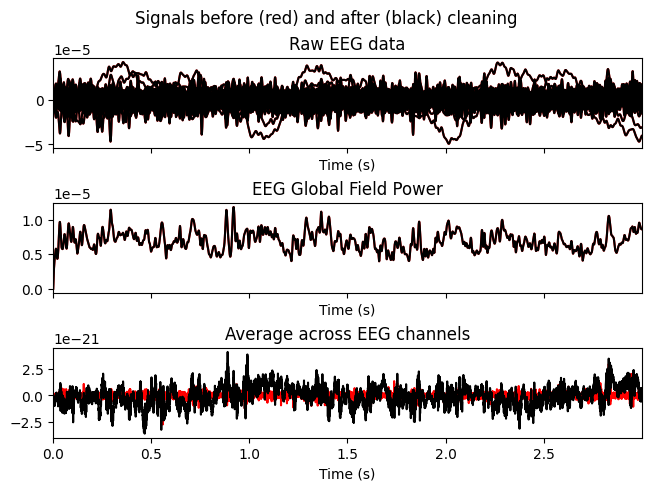

In [373]:
ica.plot_overlay(filt_raw)

Creating RawArray with float64 data, n_channels=65, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


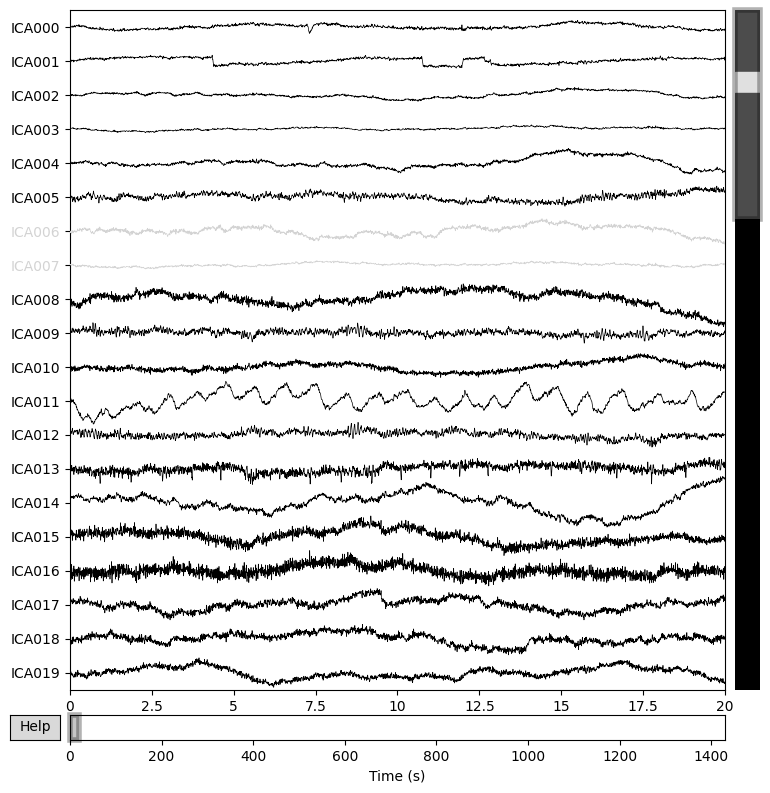

In [362]:
ica.plot_sources(raw)

In [365]:
labels_list = ic_labels["labels"]
count_other = labels_list.count("other")

print(f"Liczba komponentów oznaczonych jako 'other': {count_other}")

Liczba komponentów oznaczonych jako 'other': 27


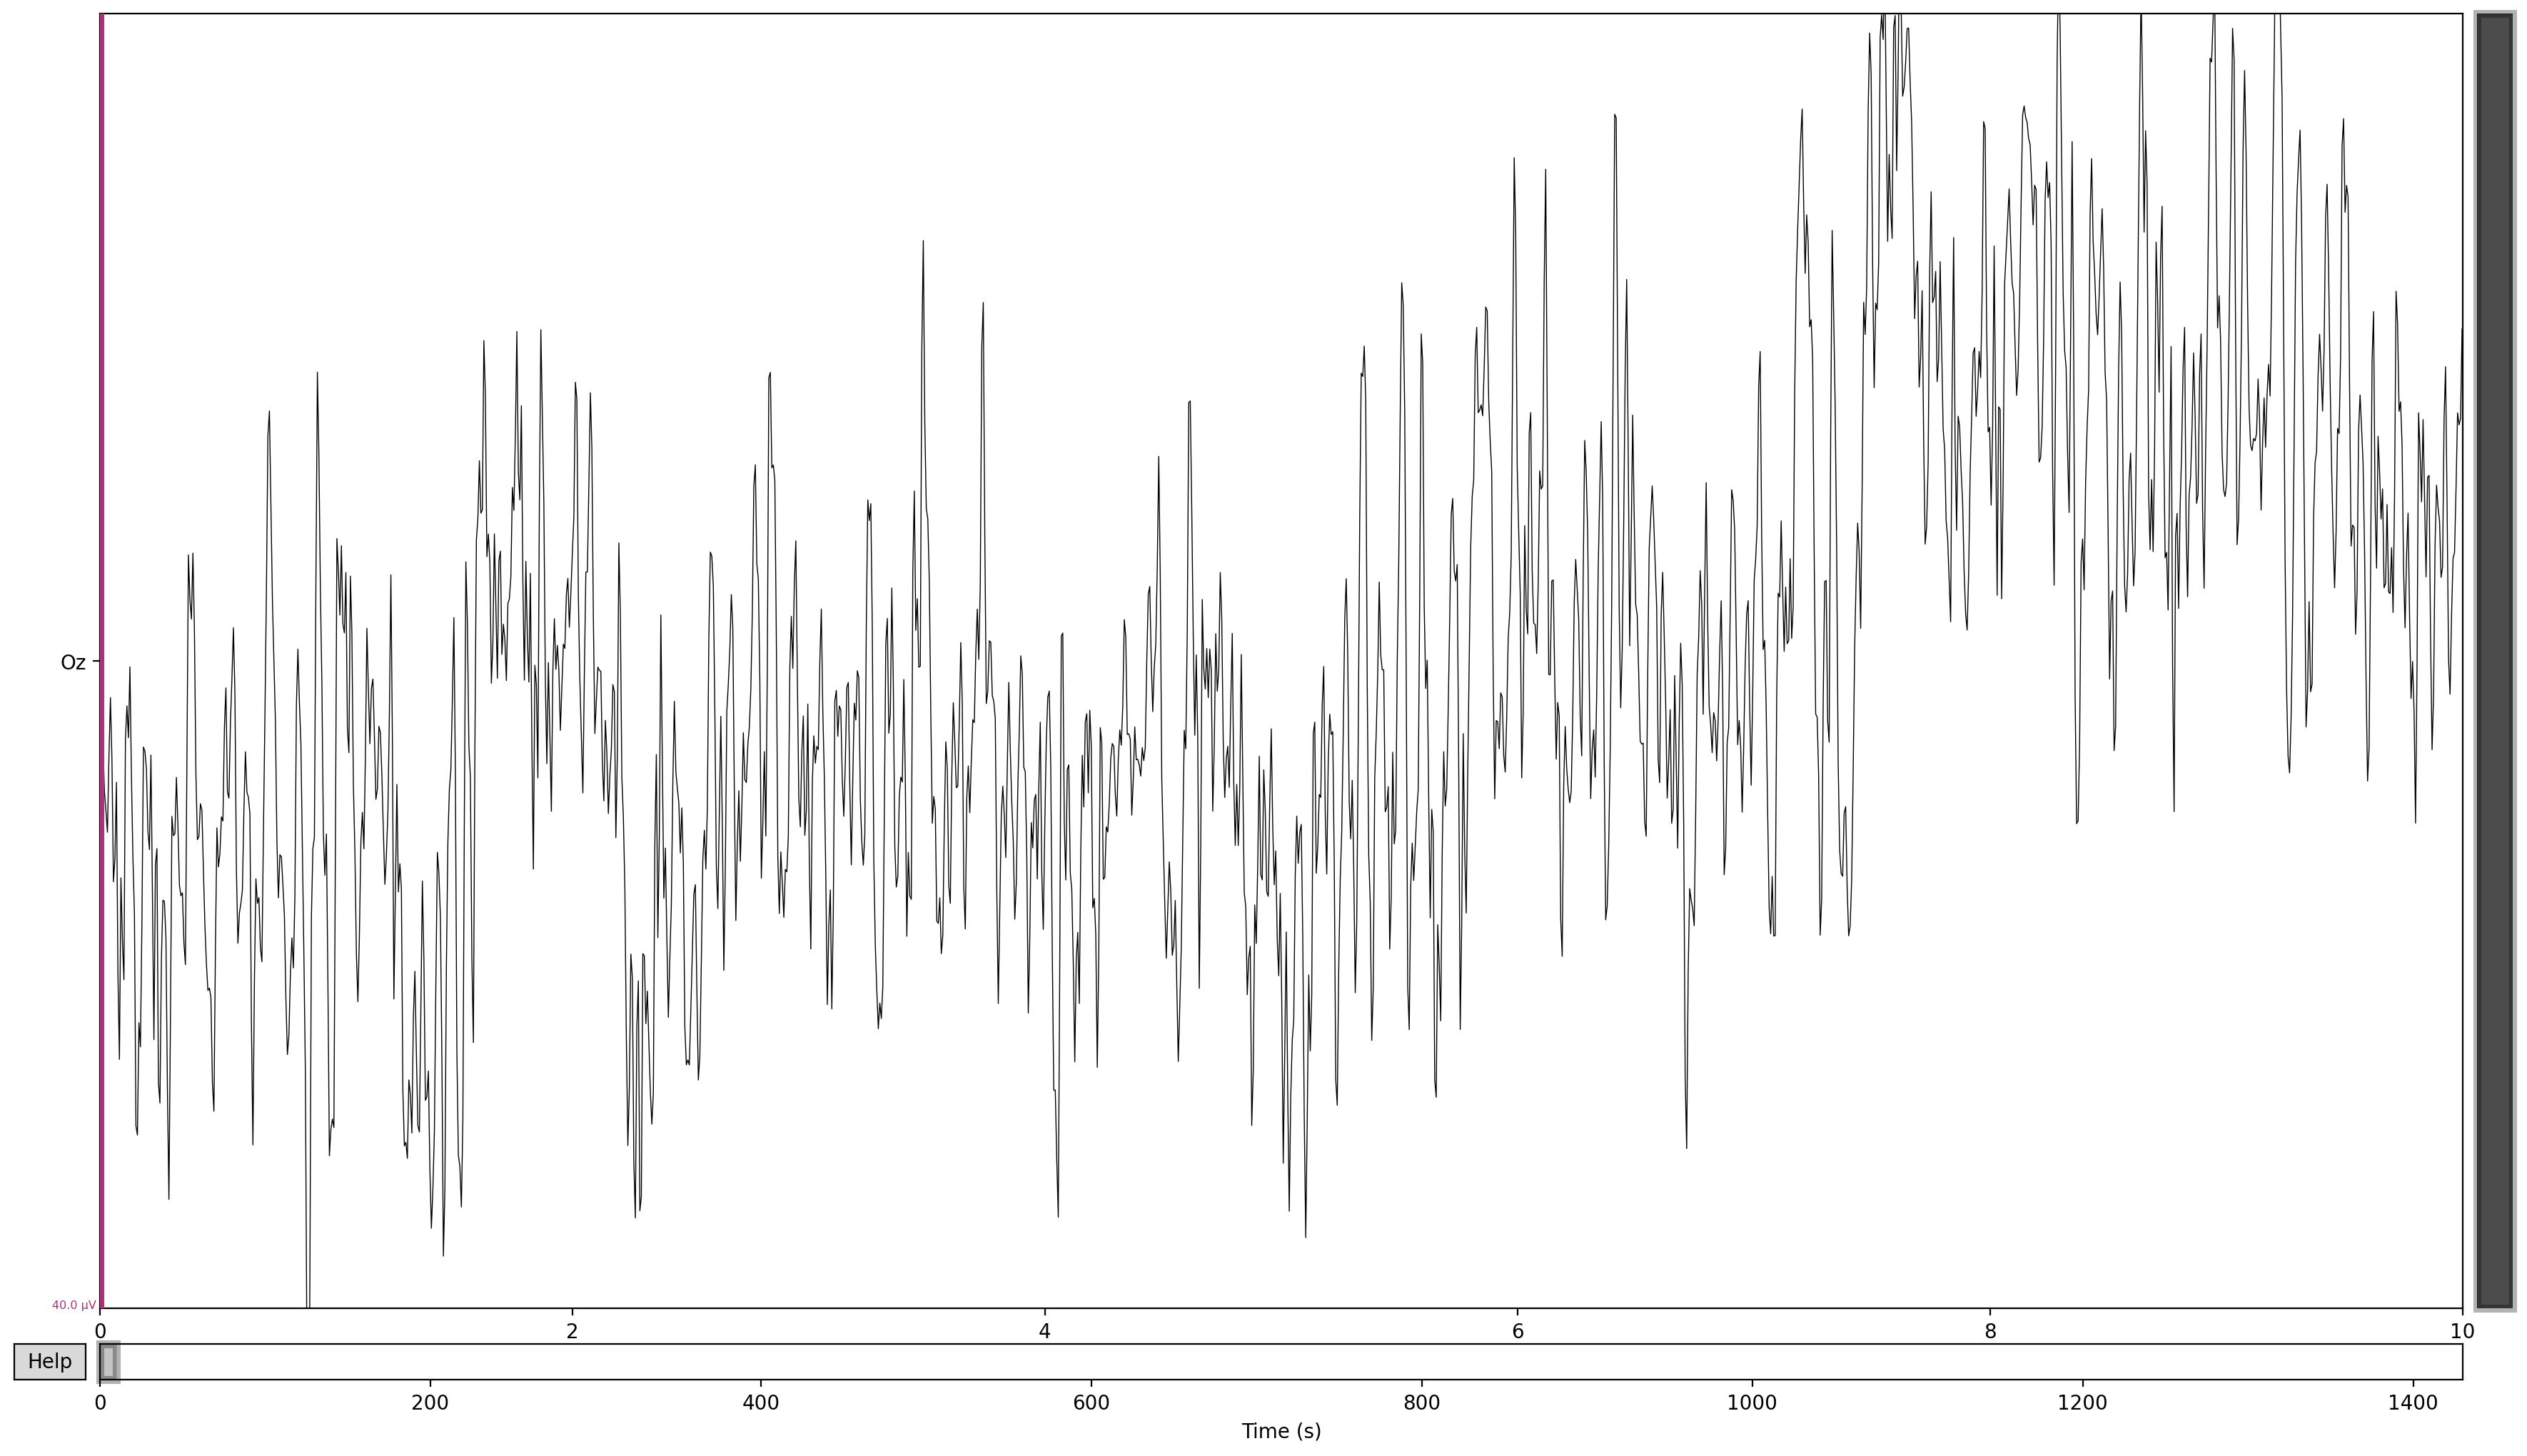

Channels marked as bad:
none


2025-05-07 16:39:57.749 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-07 16:39:57.749 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-07 16:39:57.750 Python[56149:7936693] Text input context does not respond to _valueForTIProperty:
2025-05-07 19:00:42.431 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-07 19:00:42.432 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-07 19:00:42.432 Python[56149:7936693] Text input context does not respond to _valueForTIProperty:
2025-05-07 19:00:44.008 Python[56149:7936693] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-07 19:00:44.008 Python[56149:7936693] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-07 19:00:44.008 Python[56149:7936693] Text input context does not respond to _

In [372]:
raw.plot(picks=["Oz"])